# Data Preparation - No Memory

The first step in this project is actually getting the raw stock data from [Alpha Vantage](https://www.alphavantage.co/documentation/) and processing into a form ready for training.

Before starting this process you must get an API key from this [site](https://www.alphavantage.co/support/#api-key).

## 1. Load some necessary modules

You only need to run this once on a SageMaker instance or on your PC
If you haven't run it yet, please uncomment and run.

In [33]:
#!pip install alpha_vantage

In [34]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.optimize import minimize_scalar
import seaborn as sns
import sys
import time
import yaml

from alpha_vantage.timeseries import TimeSeries
sns.set()
%matplotlib inline

## 2. Read the user defined settings

In [35]:
with open('settings.yml') as f:
    settings = yaml.safe_load(f)

## 3. Download the stock history
Note you have to manually enter your Alpha Vantage API key in the following cell.  It is unique to each user and is limited to 5 API requests per minute and 500 requests per day, so please don't use someone else's key.

In [36]:
# Set your API key
api_key = 'AIM9J0PA8YV2A12F'

# Format connection
ts = TimeSeries(key=api_key, output_format='pandas')

# Read saved data if it exists
if os.path.isfile('stock-data.pkl'):
    saved_stocks = pd.read_pickle('stock-data.pkl')
    saved_stock_names = saved_stocks.columns.to_list()
else:
    saved_stock_names = []

if os.path.isfile('volume-data.pkl') and os.path.isfile('stock-data.pkl'):
    saved_volume = pd.read_pickle('volume-data.pkl')
    saved_volume_names = saved_volume.columns.to_list()
else:
    saved_volume_names = []
    
# To avoid hitting the 5 requests per minute, we only pull 1 per 12 sec
times = []
stocks = []
volume = []
failed = []
for ticker in [t for t in settings['tickers'] if t != settings['sp500']]:
    if (ticker in saved_stock_names) and (ticker in saved_volume_names):
        stocks.append(saved_stocks.loc[:, [ticker]])
        volume.append(saved_volume.loc[:, [ticker]])
    else:
        if len(times) >= 5:
            delta = 61 - (time.time() - times[-5])
            if delta > 0:
                print("Taking a {:.0f}s break to avoid 5 req/min limit.".format(delta))
                time.sleep(delta)
        
        print("Reading {} from API.".format(ticker))
        try:
            data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')            
            data.sort_index(inplace=True)
            
            stocks.append(data.loc[settings['data_start']:settings['data_end'], ['5. adjusted close']])
            stocks[-1].rename(columns={'5. adjusted close': ticker}, inplace=True)
            
            volume.append(data.loc[settings['data_start']:settings['data_end'], ['6. volume']])
            volume[-1].rename(columns={'6. volume': ticker}, inplace=True)
        except:
            print("\tFailed to pull {} from API.".format(ticker))
            failed.append(ticker)
        times.append(time.time())

stocks = pd.concat(stocks, axis=1)
stocks.to_pickle('stock-data.pkl')

volume = pd.concat(volume, axis=1)
volume.to_pickle('volume-data.pkl')

if len(failed) > 0:
    print("Failed to get following tickers from API:")
    print(failed)

Reading AAP from API.
Reading ACN from API.
Reading ADBE from API.
Reading AFL from API.
Reading ALB from API.
Taking a 53s break to avoid 5 req/min limit.
Reading ALK from API.
Taking a 0s break to avoid 5 req/min limit.
Reading AOS from API.
Reading ATVI from API.
Taking a 0s break to avoid 5 req/min limit.
Reading AYI from API.
Reading MMM from API.


Plot the data to visually check for bad data.  You may want to manually play with the plotting to find data of interest.

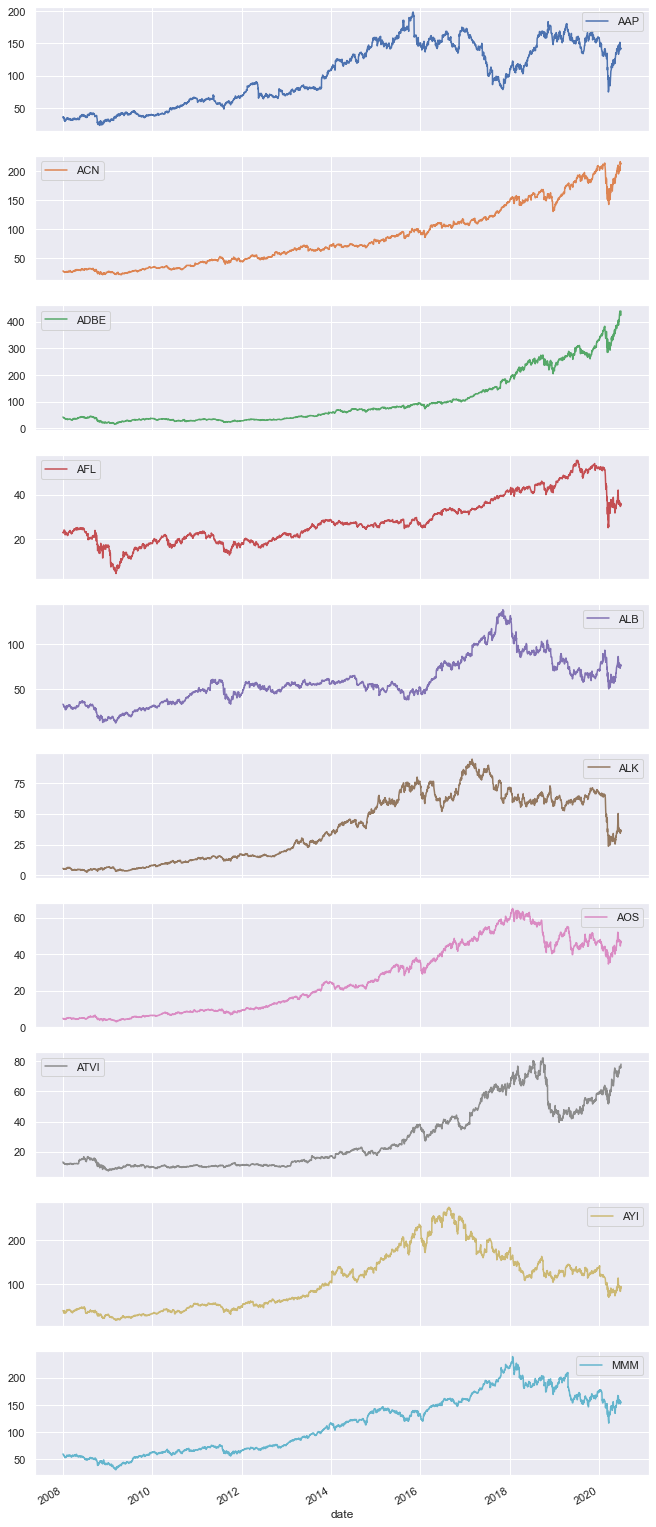

In [37]:
stock_names = stocks.columns.tolist()
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

First thing to notice is not all stocks have data for the full date range.  Since we need a full dataset to train, we will delete these stocks.

In [38]:
# Here are the stocks with NAN values.  Make sure this matches the plots above.
print(stocks.columns[stocks.isna().any()])
print("\nThere are {} stocks that lack data.".format(sum(stocks.isna().any())))

Index([], dtype='object')

There are 0 stocks that lack data.


In [39]:
# Now we delete the imcomplete stocks
stocks = stocks.loc[:, ~stocks.isna().any()]
stocks.shape

(3148, 10)

If you see any data with drop outs, you may wish to reload to see if the source is defective or if there was an issue in the download.  
I will also 'fill' any missing data with a linear interpolation.

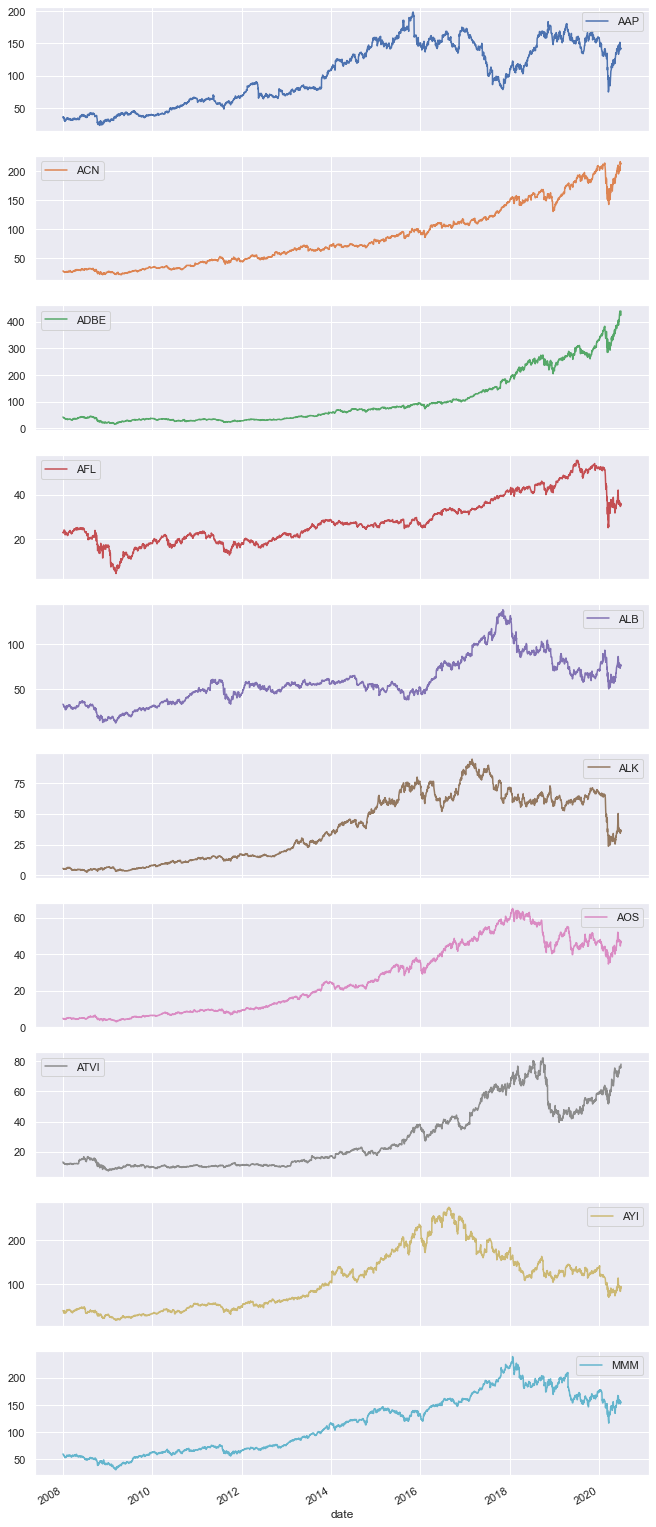

In [40]:
stocks = stocks.replace(0, np.nan).interpolate()
_ = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

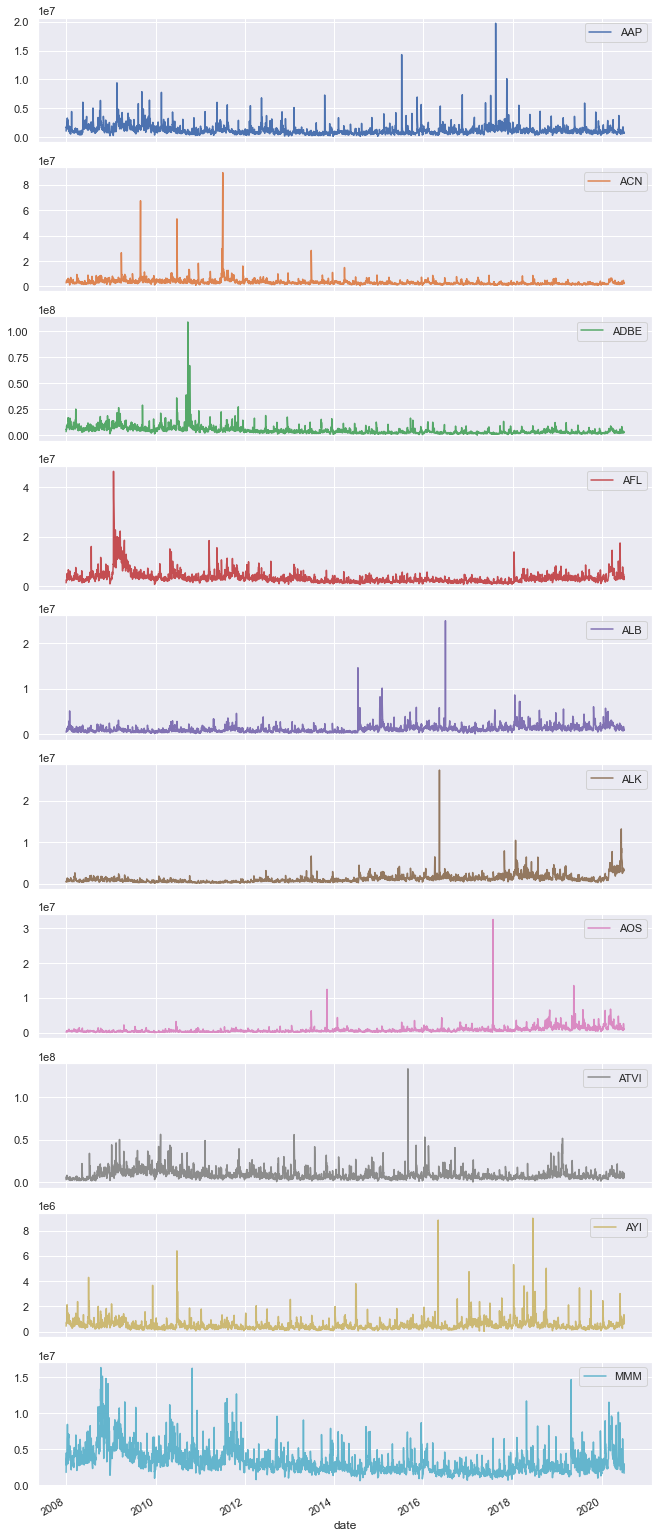

In [41]:
volume = volume.replace(0, np.nan).interpolate()
_ = volume.plot(figsize=(11, 3*volume.shape[1]), subplots=True)
plt.show()

**Now that's a pretty dataset!!!**    
Let's create a signals dataframe to add the following generated signals.

In [42]:
signals = pd.DataFrame(index=stocks.index)

## 4. Create technical analysis signals
Here we will extract the signals used in some classical technical analysis strategies and use them as input to our Reinforcement Learning model.

### Simple 20-Day Moving Average (SMA20)
A standard strategy is to buy when the price crosses the 20-day SMA from below and sell when it crosses from above.
Therefore we need to calculate the 20-day SMA and determine the crosses from above and below.  There is also a slight time delay since on day t when we can trade we do not know the closing price for that day.

In [43]:
sma20 = stocks.rolling(window=20).mean().iloc[19:]

Make a pretty plot to verify calculation.

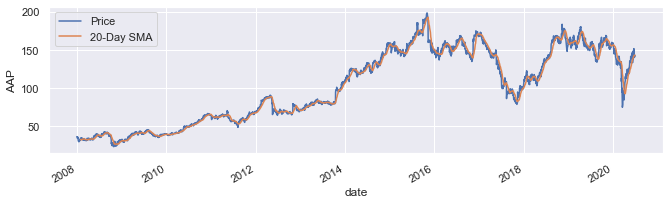

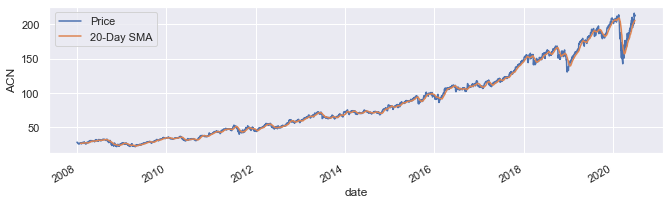

In [44]:
for s in stock_names[:2]:
    ax = stocks.loc[:, s].plot(figsize=(11, 3), label="Price")
    _ = sma20.loc[:, s].plot(ax=ax, label="20-Day SMA")
    ax.set_ylabel(s)
    plt.legend()
    plt.show()

Let's do it again but zoomed this time.

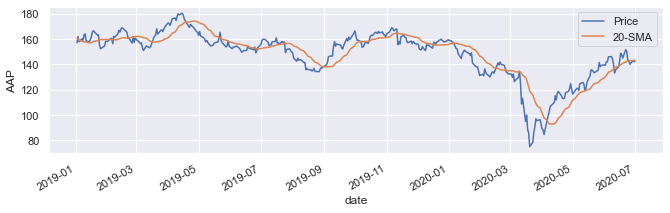

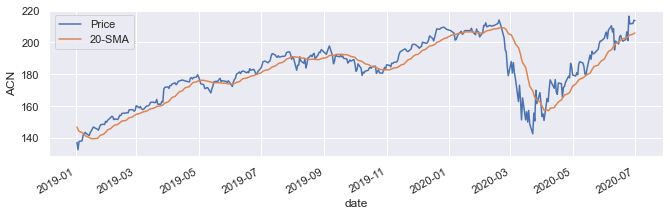

In [45]:
for s in stock_names[:2]:
    ax = stocks.loc['2019-01-01':, s].plot(figsize=(11, 3), label="Price")
    _ = sma20.loc['2019-01-01':, s].plot(ax=ax, label="20-SMA")
    ax.set_ylabel(s)
    plt.legend()
    plt.show()

#### So the SMA looks good, now detect the cross overs
We will use the following convention:    
*  0 = no crossing    
* +1 = price crossing from below (buy)
* -1 = price crossing from above (sell)

In [46]:
# Initialize to zero (no crossing)
sma20_crosses = sma20.iloc[1:, :].copy(deep=True)
sma20_crosses.loc[:, :] = 0

# Determine the deltas for the previous 2 days and any crosses
deltas = (sma20.iloc[1:, :] - stocks.iloc[20:, :]).values
crosses = deltas[:-1] * deltas[1:] <= 0
for s in range(len(stock_names)):
    for d in range(1, deltas.shape[0]):
        if crosses[d-1, s]:
            if deltas[d, s] >= 0:
                sma20_crosses.iloc[d, s] = -1
            else:
                sma20_crosses.iloc[d, s] = 1
sma20_crosses.replace(False, 0, inplace=True)

As always make a pretty plot.

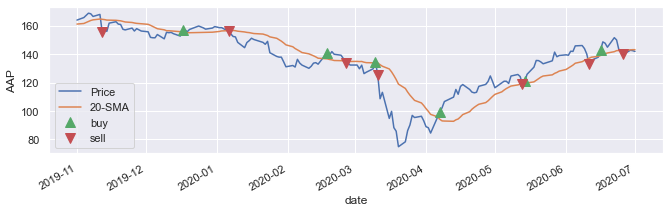

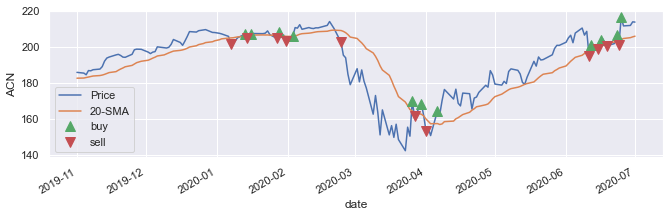

In [47]:
start = '2019-11-01'
for s in stock_names[:2]:
    ax = stocks.loc[start:, s].plot(figsize=(11, 3), label="Price")
    _ = sma20.loc[start:, s].plot(ax=ax, label="20-SMA")
    
    tmp = sma20_crosses.loc[start:, s]
    buy  = tmp.loc[tmp > 0]
    sell = tmp.loc[tmp < 0]
    ax.plot(buy.index, stocks.loc[buy.index, s], '^', markersize=10, color='g', label='buy')
    ax.plot(sell.index, stocks.loc[sell.index, s], 'v', markersize=10, color='r', label='sell')

    ax.set_ylabel(s)
    plt.legend()
    plt.show()

All looks good so lets add it to the signals dataframe.

In [48]:
signals = pd.concat([signals, sma20_crosses.add_prefix('sma20_')], axis=1)

#### Let's repeat for the 100-Day SMA

In [49]:
sma100 = stocks.rolling(window=100).mean().iloc[99:]

# Initialize to zero (no crossing)
sma100_crosses = sma100.iloc[1:, :].copy(deep=True)
sma100_crosses.loc[:, :] = 0

# Determine the deltas for the previous 2 days and any crosses
deltas = (sma100.iloc[1:, :] - stocks.iloc[100:, :]).values
crosses = deltas[:-1] * deltas[1:] <= 0
for s in range(len(stock_names)):
    for d in range(1, deltas.shape[0]):
        if crosses[d-1, s]:
            if deltas[d, s] >= 0:
                sma100_crosses.iloc[d, s] = -1
            else:
                sma100_crosses.iloc[d, s] = 1
sma100_crosses.replace(False, 0, inplace=True)

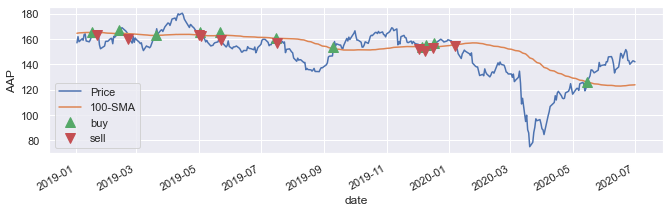

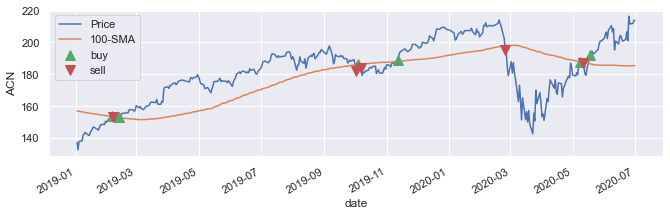

In [50]:
start = '2019-01-01'
for s in stock_names[:2]:
    ax = stocks.loc[start:, s].plot(figsize=(11, 3), label="Price")
    _ = sma100.loc[start:, s].plot(ax=ax, label="100-SMA")
    
    tmp = sma100_crosses.loc[start:, s]
    buy  = tmp.loc[tmp > 0]
    sell = tmp.loc[tmp < 0]
    ax.plot(buy.index, stocks.loc[buy.index, s], '^', markersize=10, color='g', label='buy')
    ax.plot(sell.index, stocks.loc[sell.index, s], 'v', markersize=10, color='r', label='sell')

    ax.set_ylabel(s)
    plt.legend()
    plt.show()

### Moving Average Convergence/Divergence (MACD)
The MACD is a a trend-following momentum indicator that compares 3 different Exponential Moving Averages (EMA); the 12 and 26 day EMA on the stock price plus the 9 day EMA on the difference between the 1st two.  The difference is called the MACD and the EMA of the difference is called the signal.  Similar to the SMA signals above, when the MACD and signal cross we create buy/sell signals as follows.

*  0 = no cross detected
* +1 = MACD crosses from below (buy)
* -1 = MACD crosses from above (sell)

In [51]:
macd = stocks.ewm(span=12, adjust=False).mean() - stocks.ewm(span=26, adjust=False).mean()
macd_signal = macd.ewm(span=9, adjust=False).mean()

Let's detect cross overs.

In [52]:
# Initialize to zero (no crossing)
macd_crosses = macd.iloc[1:, :].copy(deep=True)
macd_crosses.loc[:, :] = 0

# Determine the deltas for the previous 2 days and any crosses
deltas = (macd.iloc[1:, :] - macd_signal.iloc[1:, :]).values
crosses = deltas[:-1] * deltas[1:] <= 0
for s in range(len(stock_names)):
    for d in range(1, deltas.shape[0]):
        if crosses[d-1, s]:
            if deltas[d, s] >= 0:
                macd_crosses.iloc[d, s] = -1
            else:
                macd_crosses.iloc[d, s] = 1
macd_crosses.replace(False, 0, inplace=True)

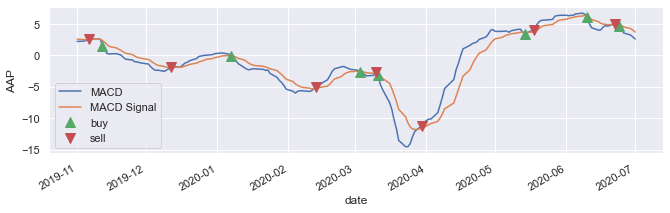

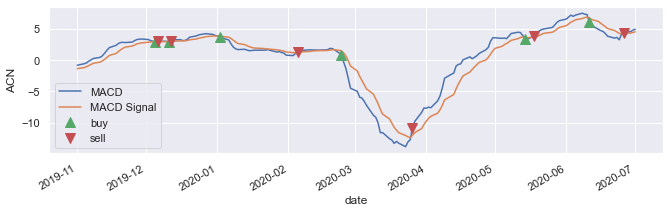

In [53]:
start = '2019-11-01'
for s in stock_names[:2]:
    ax = macd.loc[start:, s].plot(figsize=(11, 3), label="MACD")
    _ = macd_signal.loc[start:, s].plot(ax=ax, label="MACD Signal")
    
    tmp = macd_crosses.loc[start:, s]
    buy  = tmp.loc[tmp > 0]
    sell = tmp.loc[tmp < 0]
    ax.plot(buy.index, macd.loc[buy.index, s], '^', markersize=10, color='g', label='buy')
    ax.plot(sell.index, macd.loc[sell.index, s], 'v', markersize=10, color='r', label='sell')

    ax.set_ylabel(s)
    plt.legend()
    plt.show()

In [54]:
signals = pd.concat([signals, sma100_crosses.add_prefix('sma100_')], axis=1)

### Relative Strength Index (RSI)
Th relative strength index is a momentum oscillator that measures the velocity and magnitude of directional price movements.  Usually it is measured from 0 to 100 with a low or high number indicating under or over sold respectively.  Usually the trader would a lower and upper limit, which would trigger a buy or sell when crossed from the center.  Since this limit is specific to the trader, we will use a continuous normalized RSI value without buy/sell signals.  To help in training it will be normalized to -1 to 1 instead of 0 to 100.

In [55]:
# First calculte the upward and downward movements
delta = stocks.diff()
up, down = delta.copy(), delta.copy()
up[delta < 0] = 0.0
down[delta > 0] = 0.0

# Now calculate the average up and down movements of the last 14 days
up = up.rolling(14).mean()
down = down.rolling(14).mean().abs()

# Then calculate the modified RSI
rsi = 1 - 2 /(1 + up/down)
rsi.describe()

,AAP,ACN,ADBE,AFL,ALB,ALK,AOS,ATVI,AYI,MMM
count,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000
mean,0.049089,0.109210,0.102848,0.062049,0.060153,0.062753,0.084319,0.067715,0.049728,0.077867
std,0.338120,0.323444,0.319274,0.316069,0.339689,0.341286,0.332202,0.314504,0.341331,0.335942
min,-0.930189,-0.840986,-0.853372,-0.953150,-0.929367,-0.980012,-0.817971,-0.947598,-0.968164,-0.920495
25%,-0.194170,-0.136502,-0.133946,-0.145872,-0.195151,-0.172934,-0.149079,-0.150316,-0.196116,-0.153881
50%,0.063889,0.114927,0.099129,0.078119,0.067827,0.084302,0.097443,0.077654,0.070702,0.092578
75%,0.298675,0.352022,0.338543,0.289432,0.316657,0.311526,0.322846,0.281116,0.306294,0.305428
max,0.823809,0.997894,0.972093,0.923655,0.951116,0.857657,0.920316,0.917943,0.977059,0.938864


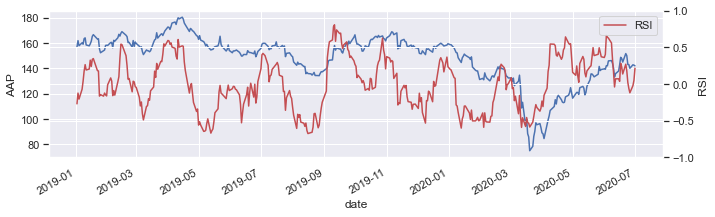

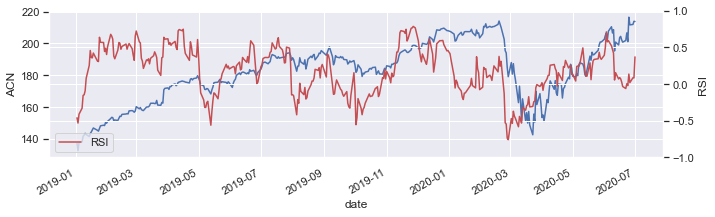

In [56]:
start = '2019-01-01'
for s in stock_names[:2]:
    ax = stocks.loc[start:, s].plot(figsize=(11, 3), label="Price")
    ax2 = ax.twinx()
    _ = rsi.loc[start:, s].plot(ax=ax2, label="RSI", c='r')
    
    ax.set_ylabel(s)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(-1, 1)
    plt.legend()
    plt.show()

In [57]:
signals = pd.concat([signals, rsi.add_prefix('rsi_')], axis=1)

### Trading volume
Trading volume is another signal often monitored by speculators however we need to normalize it for training.  Several options are available including normalizing by the market, represented by the S&P500 index.  Or we could normalize by the average volume of that specific stock.  

We have choosen to normalize the stocks 1-month (21 trading days) SMA, similar to the SMA signal above.

The volume is also extremely volatile with very large spikes.  To mitigate the chances of anomalies corrupting the system, we will limit the normalized volume to 0.1 to 10 and take the log.  This also limits the signal to (-1, 1), which is well suited for machine learning.

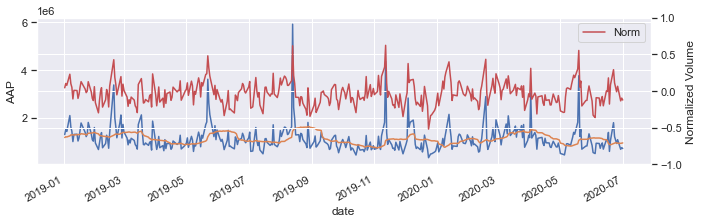

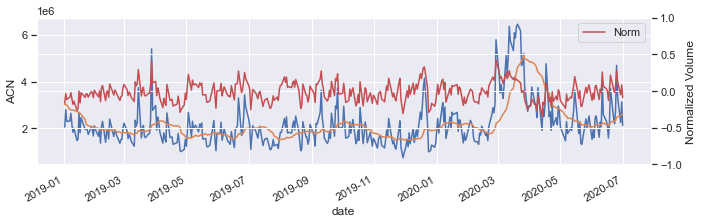

In [58]:
sma = volume.rolling(window=20).mean().iloc[19:]
normalized_volume = np.log10(np.clip(volume / sma, a_min=0.1, a_max=10))
start = '2019-01-01'
for s in stock_names[:2]:
    ax = volume.loc[start:, s].plot(figsize=(11, 3), label="Volume")
    _ = sma.loc[start:, s].plot(ax=ax, label="SMA")
    ax2 = ax.twinx()
    _ = normalized_volume.loc[start:, s].plot(ax=ax2, label="Norm", c='r')
    
    ax.set_ylabel(s)
    ax2.set_ylabel('Normalized Volume')
    ax2.set_ylim(-1, 1)
    plt.legend()
    plt.show()

In [59]:
signals = pd.concat([signals, normalized_volume.add_prefix('volume_')], axis=1)

## 5. Create 1-hot encoding for month
Most companies and markets have annual cycles that influence investment decisions so we will add time of year as an environment state.  

A major decision has to be made concerning the time dependancy.  First decision is the date categorical or quantative.  We can make it quantative by simply using the day of the year (0-d/364).  This assumes the investment environment is a continuous function through the year.  We can make each month a category, which makes Jan 31 and Feb 1 part of two distinct states.  Then we must decide if the month should be treated as an ordered (ordinal) or non-order (nominal) set.  

Due to the non-linear and dicrete events such as tax filings, we will treat the month as nominal categorical data by creating a 1-hot encoding for the month of the year.    

Note that with 1-hot encoding the first category ('jan') is not included since it's redundant.

In [60]:
month = pd.get_dummies(stocks.index.month, drop_first=True)
month.set_index(stocks.index, inplace=True)
month.columns = ['feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
print(month)
signals = pd.concat([signals, month], axis=1)

            feb  mar  apr  may  jun  jul  aug  sep  oct  nov  dec
date                                                             
2007-12-31    0    0    0    0    0    0    0    0    0    0    1
2008-01-02    0    0    0    0    0    0    0    0    0    0    0
2008-01-03    0    0    0    0    0    0    0    0    0    0    0
2008-01-04    0    0    0    0    0    0    0    0    0    0    0
2008-01-07    0    0    0    0    0    0    0    0    0    0    0
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2020-06-25    0    0    0    0    1    0    0    0    0    0    0
2020-06-26    0    0    0    0    1    0    0    0    0    0    0
2020-06-29    0    0    0    0    1    0    0    0    0    0    0
2020-06-30    0    0    0    0    1    0    0    0    0    0    0
2020-07-01    0    0    0    0    0    1    0    0    0    0    0

[3148 rows x 11 columns]


## 6. Fundemental Signals
The hardest part of getting this data was actually getting this data.  We could not find an API at a reasonable price to download it directly so it had to be manually compiled.  In the following cells we are simply compiling the csv files that were manual generated.

#### Market capitalization

`so` is the shares outstanding.  Only the dates the number of shares changed are in the dataset so we have to fill forward and then backward before multiplying by the share price.

In [62]:
so = []
for s in [s for s in stock_names if s != settings['sp500']]:
    tmp = pd.read_csv(os.path.join('ref_data', '{}_so.csv'.format(s.lower())), 
                  skipfooter=3, engine='python', usecols=[0, 1], 
                  index_col=0, parse_dates=True)
    tmp.rename(columns={'Pure Number': s}, inplace=True)
    so.append(tmp.loc[settings['data_start']:settings['data_end'], :])
so = pd.concat(so, axis=1)
so = pd.concat([pd.DataFrame(index=stocks.index), so], axis=1)
so.ffill(inplace=True)
so.bfill(inplace=True)
so = so.loc[stocks.index]

When we calculate the market capitalization we are also going to normalize across all assets at each timestep.  This means the smallest capitalized asset will be -1 and the largest +1.

In [63]:
cap = so * stocks
max_cap = cap.max(axis=1)
min_cap = cap.min(axis=1)
cap = 2 * cap.subtract(min_cap, axis='index').div(max_cap - min_cap, axis='index') - 1
cap

,AAP,ACN,ADBE,AFL,ALB,ALK,AOS,ATVI,AYI,MMM
date,,,,,,,,,,
2007-12-31,-0.875089,-0.052627,0.050630,0.007128,-0.892867,-1.000000,-0.999111,-0.665510,-0.960321,1.000000
2008-01-02,-0.872254,-0.031781,0.046021,0.016998,-0.890304,-1.000000,-0.998391,-0.673333,-0.958672,1.000000
2008-01-03,-0.869930,-0.048598,0.048590,0.030962,-0.891299,-1.000000,-0.998590,-0.679103,-0.958844,1.000000
2008-01-04,-0.878228,-0.052176,0.023467,0.036376,-0.892056,-1.000000,-0.999829,-0.676116,-0.961097,1.000000
2008-01-07,-0.870343,-0.071457,0.028429,0.062539,-0.891187,-0.998927,-1.000000,-0.671873,-0.961479,1.000000
...,...,...,...,...,...,...,...,...,...,...
2020-06-25,-0.937540,0.302921,1.000000,-0.783931,-0.957297,-0.991334,-0.974704,-0.463680,-1.000000,-0.170031
2020-06-26,-0.937149,0.303844,1.000000,-0.786132,-0.954639,-0.991629,-0.973570,-0.448736,-1.000000,-0.161944
2020-06-29,-0.936703,0.313264,1.000000,-0.781079,-0.954440,-0.990312,-0.972615,-0.453475,-1.000000,-0.140045


In [64]:
signals = pd.concat([signals, cap.add_prefix('cap_')], axis=1)

### Price to Earnings Ratio (pe)
Similar to the shares outstanding we have to forward and back fill the Net Income `ni` before calulating the `pe = price * so / ni`.  

In [66]:
ni = []
for s in [s for s in stock_names if s != settings['sp500']]:
    tmp = pd.read_csv(os.path.join('ref_data', '{}_ni.csv'.format(s.lower())), 
                  skipfooter=3, engine='python', usecols=[0, 1], 
                  index_col=0, parse_dates=True)
    tmp.rename(columns={'In US dollars per year': s}, inplace=True)
    ni.append(tmp.loc[settings['data_start']:settings['data_end'], :])
ni = pd.concat(ni, axis=1)
ni = pd.concat([pd.DataFrame(index=stocks.index), ni], axis=1)
ni.ffill(inplace=True)
ni.bfill(inplace=True)
ni = ni.loc[stocks.index]

Like market capitalization we are also going to normalize across all assets at each timestep. This means the smallest pe asset will be -1 and the largest +1.

In [67]:
pe = so * stocks / ni
max_pe = pe.max(axis=1)
min_pe = pe.min(axis=1)
pe = 2 * pe.subtract(min_pe, axis='index').div(max_pe - min_pe, axis='index') - 1
pe

,AAP,ACN,ADBE,AFL,ALB,ALK,AOS,ATVI,AYI,MMM
date,,,,,,,,,,
2007-12-31,-0.785174,-0.793970,-0.394270,-0.817454,-0.815147,-1.000000,-0.913898,1.000000,-0.888244,-0.901117
2008-01-02,-0.769403,-0.773763,-0.376918,-0.802736,-0.800689,-1.000000,-0.909941,1.000000,-0.877766,-0.891713
2008-01-03,-0.757537,-0.773350,-0.360590,-0.790537,-0.798039,-1.000000,-0.911243,1.000000,-0.875509,-0.886153
2008-01-04,-0.780673,-0.776753,-0.385200,-0.790294,-0.801785,-1.000000,-0.920577,1.000000,-0.885361,-0.887044
2008-01-07,-0.770111,-0.795558,-0.396227,-0.791485,-0.808429,-1.000000,-0.926163,1.000000,-0.893890,-0.896948
...,...,...,...,...,...,...,...,...,...,...
2020-06-25,1.000000,-0.839656,-0.605094,-0.994979,-0.940264,-1.000000,-0.918126,-0.760169,-0.962786,-0.920429
2020-06-26,1.000000,-0.839296,-0.605586,-0.994962,-0.935602,-1.000000,-0.915189,-0.752250,-0.962660,-0.918627
2020-06-29,1.000000,-0.846733,-0.620267,-0.998434,-0.938726,-1.000000,-0.914956,-0.765100,-0.962370,-0.922052


In [68]:
signals = pd.concat([signals, pe.add_prefix('pe_')], axis=1)

## 7. Pack up for training
Let's drop the np.nan from the start of the signals due to the SMA-100 signal.

In [69]:
print(signals.shape)
first_good_row = np.argmin(signals.isnull().any(axis=1).values)
signals = signals.iloc[first_good_row:]
start_date = signals.index[0].strftime('%Y-%m-%d')
print(signals.shape)
print(start_date)

(3148, 71)
(3048, 71)
2008-05-23


For the stocks we need one extra day at the start to capture the previous day's price.

In [70]:
stocks_clean = stocks.iloc[np.where(stocks.index == start_date)[0][0]-1:]
print(stocks.shape)
print(stocks_clean.shape)
print(stocks_clean.index[0])

(3148, 10)
(3049, 10)
2008-05-22 00:00:00


In [71]:
stocks_clean.to_csv(os.path.join('src', 'prices.csv'))

Let's do a final plot to verify the signals look god and save for the training step.    

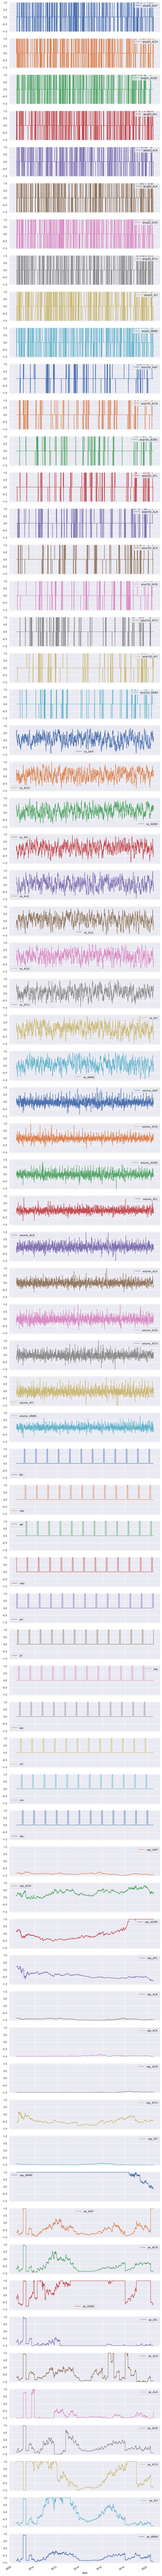

In [72]:
ax = signals.plot(figsize=(11, 3*signals.shape[1]), subplots=True, ylim=(-1.05,1.05))
plt.show()

The signals should all be between -1 and 1.

In [73]:
print(np.max(signals.values))
print(np.min(signals.values))
print(signals.shape)

1.0
-1.0
(3048, 71)


In [74]:
signals.to_csv(os.path.join('src', 'signals.csv'))